### Imports

In [15]:
#imports
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.linear_model as skl
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import matplotlib 
matplotlib.rcParams['text.usetex']=True
import matplotlib.pyplot as plt
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from random import random, seed
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
#newer imports
from random import random, seed
from sklearn.linear_model import SGDRegressor
from matplotlib import cm
import seaborn as sns

# Calculates value of Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

# Creates design matrix
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Calculates R²-score
def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)

# Calculates mean squared error
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def sigmoid(x):
    return 1/(1 + np.exp(-x))


# Feed-forward neural network

In [2]:
class NN:
    def __init__(
            self,
            X_data,
            Y_data,
            n_neurons=50,
            epochs=20,
            batch_size=10,
            eta=0.01, 
            lmbd=0.0, 
            n_categories = 1, 
            hidden_act_function = "sigmoid",
            last_act_function = "return input",
            gamma=0.0, 
            model="Regressor"):
        self.model = model
        
        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_neurons = n_neurons
        #self.model = model
        if (model == "Regressor"):
            self.n_categories = 1
        elif (model == "Classifier"): 
            self.n_categories = n_categories
        
        self.n_layers = len(self.n_neurons)
        if (hidden_act_function=="sigmoid"): 
            self.hl_act_function = self.sigmoid
            self.hl_act_f_der = self.sigmoid_derivative
        elif (hidden_act_function=="reLU"): 
            self.hl_act_function = self.reLU
            self.hl_act_f_der = self.reLU_derivative
        elif (hidden_act_function=="leakyReLU"): 
            self.hl_act_function = self.leaky_ReLU
            self.hl_act_f_der = self.leaky_ReLU_derivative
        else: 
            # Setting sigmoid to default activation function
            # in the hidden layers
            self.hl_act_function = self.sigmoid
        
        if (last_act_function=="return input"): 
            self.ll_act_function = self.return_input
        elif (last_act_function=="softmax"): 
            self.ll_act_function = self.softmax
        elif (last_act_function == "binary classifier"):
            self.ll_act_function = self.binary_classifier
        else: 
            # Setting return input as default last layer
            # activation function
            self.ll_act_function = self.return_input
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        self.gamma = gamma
        
        print("MODEL: " + self.model)
        print("Hidden layer activation function: " + hidden_act_function) 
        print("Output layer activation function: " + last_act_function)
        

        self.create_biases_and_weights()
    
    
    # Defining activation functions 
    # Hidden layer activation functions
    def sigmoid(self, x): 
        output = 1.0/(1.0+np.exp(-x))
        return output
    
    def sigmoid_derivative(self, x): 
        a = 1.0/(1.0+np.exp(-x))
        output = a*(1-a)
        return output
    
    def reLU(self, x): 
        x = np.maximum(0.0, x)
        return x
    
    def reLU_derivative(self, x): 
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def leaky_ReLU(self, x):
        y1 = ((x>0)*x)
        y2 = ((x<=0)*x*0.01)
        return y1+y2
    
    def leaky_ReLU_derivative(self, x): 
        x[x<=0] = 0.01
        x[x>0] = 1
        return x
    
    # Last layer activation functions
    def softmax(self, x): 
        exp_term = np.exp(x)
        output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
        return output
    
    def return_input(self, x):
        output = x
        return output
    
    def binary_classifier(self, x): 
        x[x<0.5] = 0
        x[x>=0.5] = 1
        return x

    def create_biases_and_weights(self):
        self.hidden_weights = []
        self.hidden_bias = []
        # In case of momentum SGD
        self.prev_grad_hidden_weights = []
        self.prev_grad_hidden_bias = []
        # First hidden layer
        weights, bias = self.add_layer(self.n_features, self.n_neurons[0])
        self.hidden_weights.append(weights)
        self.hidden_bias.append(bias)
        # Momentum SGD
        p_g_weights, p_g_bias = self.add_zero_layer(self.n_features, self.n_neurons[0])
        self.prev_grad_hidden_weights.append(p_g_weights)
        self.prev_grad_hidden_bias.append(p_g_bias)
        # 2nd-to next to last hidden layers
        for i in range(1, self.n_layers): 
            weights, bias = self.add_layer(self.n_neurons[i-1], self.n_neurons[i])
            self.hidden_weights.append(weights)
            self.hidden_bias.append(bias)
            # Momentum SGD
            prev_grad_weights, prev_grad_bias = self.add_zero_layer(self.n_neurons[i-1], self.n_neurons[i])
            self.prev_grad_hidden_weights.append(prev_grad_weights)
            self.prev_grad_hidden_bias.append(prev_grad_bias)
        # Output layer
        weights, bias = self.add_layer(self.n_neurons[-1], self.n_categories)
        self.output_weights = weights
        self.output_bias = bias
        # Momentum SGD
        prev_grad_weights, prev_grad_bias = self.add_zero_layer(self.n_neurons[-1], self.n_categories)
        self.prev_grad_output_weights = prev_grad_weights
        self.prev_grad_output_bias = prev_grad_bias
        
        
        
    def add_layer(self, n_l_1, n_l): 
        weights = np.random.randn(n_l_1, n_l) 
        bias = np.zeros(n_l) + 0.01
        return weights, bias
    def add_zero_layer(self, n_l_1, n_l): 
        weights = np.zeros((n_l_1, n_l))
        bias = np.zeros(n_l)
        return weights, bias

    def feed_forward(self):
        # feed-forward for training
        self.z_h = []
        self.a_h = []
        self.a_h_der = []
        # First layer
        z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
        a_h_temp = self.hl_act_function(z_h_temp)
        a_h_der_temp = self.hl_act_f_der(z_h_temp)
        self.z_h.append(z_h_temp)
        self.a_h.append(a_h_temp)
        self.a_h_der.append(a_h_der_temp)
        
        # Hidden layer
        for layer in range(1, self.n_layers): 
            z_h_temp = np.matmul(self.a_h[-1], self.hidden_weights[layer]) + self.hidden_bias[layer]
            a_h_temp = self.hl_act_function(z_h_temp)
            a_h_der_temp = self.hl_act_f_der(z_h_temp)
            self.z_h.append(z_h_temp)
            self.a_h.append(a_h_temp)
            self.a_h_der.append(a_h_der_temp)
            
        # ouput
        self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
        self.a_o = self.ll_act_function(self.z_o)
       

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights[0]) + self.hidden_bias[0]
        a_h = self.hl_act_function(z_h)
        for layer in range(1, self.n_layers): 
            z_h = np.matmul(a_h, self.hidden_weights[layer]) + self.hidden_bias[layer]
            a_h = self.hl_act_function(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        a_o = self.ll_act_function(z_o)
        return a_o

    def backpropagation(self):
        error_output = self.a_o - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
        # Lists for storing gradients in hidden layers
        self.hidden_weights_gradients = []
        self.hidden_bias_gradients = []
        # Output weights and bias gradient
        #prev_grad = self.output_wei
        self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)
        # Looping through all layers
        for l in range(1, self.n_layers): 
            weights_g, bias_g = self.layer_gradient(self.a_h[self.n_layers-l-1].T, error_hidden)
            self.hidden_weights_gradients.append(weights_g)
            self.hidden_bias_gradients.append(bias_g)
            error_hidden = np.matmul(error_hidden, self.hidden_weights[self.n_layers-l].T)*self.a_h_der[self.n_layers-l-1]
        
        # Last layer
        hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        hidden_bias_gradient = np.sum(error_hidden, axis=0)
        self.hidden_weights_gradients.append(hidden_weights_gradient)
        self.hidden_bias_gradients.append(hidden_bias_gradient)
        
        # Calculating new weights and biases
        if (self.lmbd > 0.0):
            self.regularization()
        
        
        if (self.gamma > 0.0): 
            # with momentum
            self.update_layers_momentum()
        else: 
            # without momentum
            self.update_layers()
        
    def layer_gradient(self, input_layer, error): 
        weights_gradient = np.matmul(input_layer, error)
        bias_gradient = np.sum(error, axis=0)
        return weights_gradient, bias_gradient
    
    def regularization(self): 
        self.output_weights_gradient -= self.lmbd*self.output_weights
        for layer in range(self.n_layers): 
            self.hidden_weights_gradients[layer] -= self.lmbd*self.hidden_weights[self.n_layers-1-layer]
        
    def update_layers(self): 
        self.output_weights -= self.eta*self.output_weights_gradient
        self.output_bias -= self.eta*self.output_bias_gradient
        for layer in range(self.n_layers): 
            self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
            self.hidden_bias[layer] -= self.eta*self.hidden_bias_gradients[self.n_layers-1-layer]
    
    def update_layers_momentum(self): 
        if (self.lmbd > 0.0): 
            self.regularization()
        # Updating previous gradient (with learning parameter and gamma)
        self.prev_grad_ouput_weights = self.add_momentum(self.prev_grad_output_weights, self.output_weights_gradient)
        self.prev_grad_ouput_bias = self.add_momentum(self.prev_grad_output_bias, self.output_weights_gradient)
        for layer in range(self.n_layers):
            self.prev_grad_hidden_weights[layer] = self.add_momentum(self.prev_grad_hidden_weights[layer], self.hidden_weights_gradients[self.n_layers-1-layer])
            self.prev_grad_hidden_bias[layer] = self.add_momentum(self.prev_grad_hidden_bias[layer], self.hidden_bias_gradients[self.n_layers-1-layer])
        
        # Updating weights and biases
        self.output_weights -= self.prev_grad_output_weights
        self.output_bias -= self.prev_grad_output_bias
        for layer in range(self.n_layers): 
            self.hidden_weights[layer] -= self.prev_grad_hidden_weights[layer]
            self.hidden_bias[layer] -= self.prev_grad_hidden_bias[layer]
            
            
        
    def add_momentum(self, prev_grad, gradient): 
        return self.gamma*prev_grad + self.eta*gradient
    
    def predict(self, X):
        if (self.model == "Regressor"):
            pred = self.feed_forward_out(X)
            return pred
        elif (self.model == "Classifier"):
            probabilities = self.feed_forward_out(X)
            return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]
                
                
                self.iteration = j
                self.feed_forward()
                self.backpropagation()
        #if (self.model == "Classifier"): 
            #print("Classifier")
            
        #if (self.model == "Regressor"): 
            #print("Epoch {}".format(i))
            #print("MSE Train: ", MSE(self.Y_data, self.a_o))
            #print("R2 Train ", R2(self.Y_data, self.a_o))
         
        
            #print("Prediction: ", self.z_o)
            #print("Data: ", self.Y_data)

            
            

In [35]:
np.random.seed(3113)

N = 40
degree = 20
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
mx, my = np.meshgrid(x, y)
z = FrankeFunction(mx, my) + 0.2*np.random.randn(N, N)
z = z.reshape(N*N, 1)
X = create_X(mx, my, degree)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
X_train_mean = np.mean(X_train, axis=0); X_test_mean = np.mean(X_test, axis=0)
z_train_mean = np.mean(z_train, axis=0); z_test_mean = np.mean(z_test, axis=0)
X_train -= X_train_mean; X_test -= X_test_mean; z_train -= z_train_mean; z_test -= z_test_mean 
print(X_train.shape)

dNN = NN(X_train,
         z_train,
         n_neurons=[10], 
         epochs=20,
         batch_size=10,
         eta=0.1, 
         lmbd=0.01, 
         n_categories = 1, 
         hidden_act_function = "reLU",
         gamma = 0.0, 
         last_act_function = "return input",
         model="Regressor")
dNN.train()
train_predict = dNN.predict(X_train)
test_predict = dNN.predict(X_test)
print("MSE train: ", MSE(train_predict, z_train))
print("R2 train: ", R2(train_predict, z_train))
print("MSE test: ", MSE(test_predict, z_test))
print("R2 test: ", R2(test_predict, z_test))

(1280, 231)
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input


<ipython-input-2-ab15517cbe00>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-2-ab15517cbe00>:200: RuntimeWarning: overflow encountered in matmul
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-2-ab15517cbe00>:200: RuntimeWarning: invalid value encountered in multiply
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-2-ab15517cbe00>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-2-ab15517cbe00>:206: RuntimeWarning: invalid value encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-2-ab15517cbe00>:216: RuntimeWarning: invalid value encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)


MSE train:  nan
R2 train:  nan
MSE test:  nan
R2 test:  nan


MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  sigmoid
R2 score on test set:  -19.258362619252427
R2 score on train set:  -19.822148878455643
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  reLU
R2 score on test set:  -297.00130795547364
R2 score on train set:  -357.12395025659663
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  1e-07
Activation function =  leakyReLU
R2 score on test set:  -191.31816496470213
R2 score on train set:  -215.08895578142622
MODEL: Regressor
Hidden layer activation function: sig

<ipython-input-2-ab15517cbe00>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-2-ab15517cbe00>:200: RuntimeWarning: overflow encountered in matmul
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-2-ab15517cbe00>:200: RuntimeWarning: invalid value encountered in multiply
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-2-ab15517cbe00>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-2-ab15517cbe00>:206: RuntimeWarning: invalid value encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-2-ab15517cbe00>:216: RuntimeWarning: invalid value encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Activation function =  reLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input


<ipython-input-2-ab15517cbe00>:182: RuntimeWarning: invalid value encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.01
Activation function =  leakyReLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input


<ipython-input-2-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-2-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  sigmoid
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  reLU
R2 score on test set:  nan
R2 score on train set:  nan
MODEL: Regressor
Hidden layer activation function: leakyReLU
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.1
Activation function =  leakyReLU
R2 score on test set:  nan
R2 score on train set:  nan


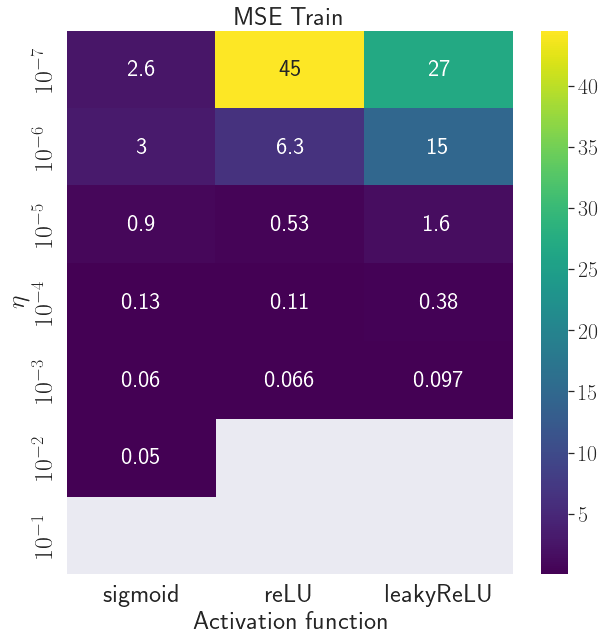

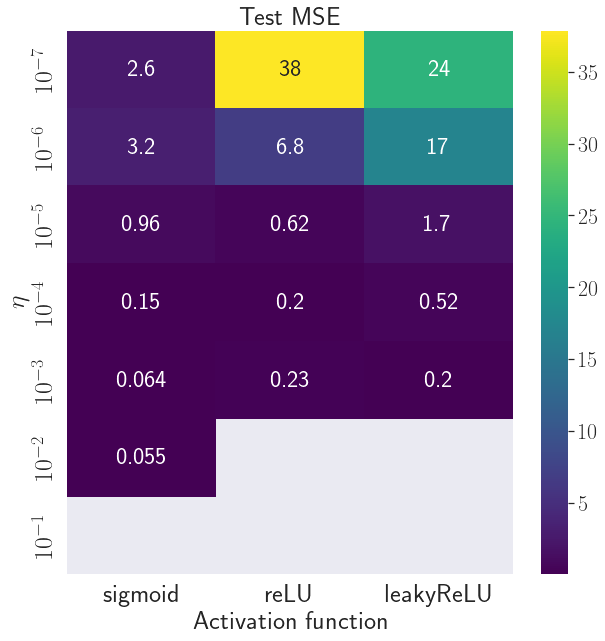

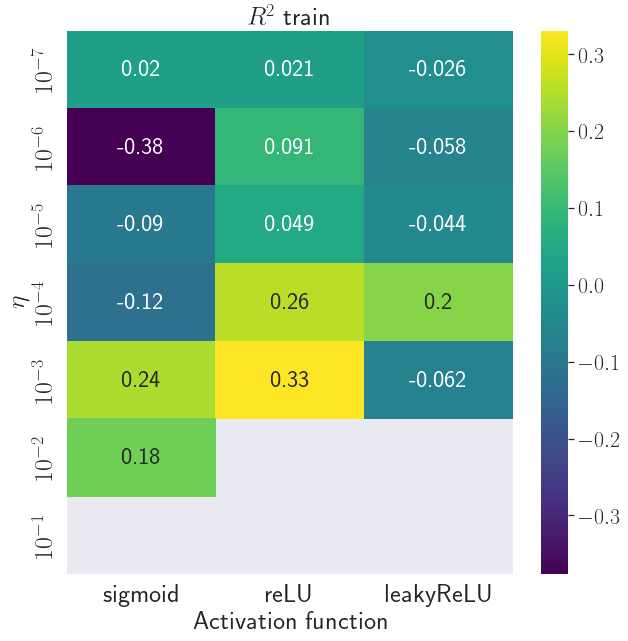

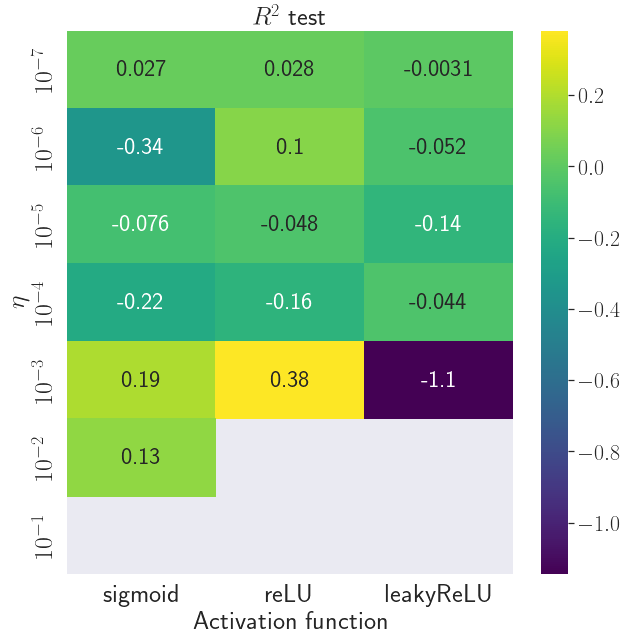

In [33]:
# TEST activation functions in hidden layers


act_functions = ["sigmoid", "reLU", "leakyReLU"]

eta_vals = np.logspace(-7, -1, 7)

tickseta_vals = []
for i in range(len(eta_vals)): 
    tickseta_vals.append(str(r'$10^{%.d}$'%(np.log10(eta_vals[i]))))
    
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
#DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
# grid search
for i, eta in enumerate(eta_vals):
    for j, function in enumerate(act_functions):
        dNN = NN(X_train,
                 z_train,
                 n_neurons=[100],
                 epochs=50,
                 batch_size=10,
                 eta=eta, 
                 lmbd=0.0001, 
                 n_categories = 1, 
                 hidden_act_function = function,
                 gamma = 0.0, 
                 last_act_function = "return input",
                 model="Regressor")
        #dNNscikit = MLPRegressor(hidden_layer_sizes=(100,100,), activation='logistic', solver='sgd', alpha=lmbd,
        #                       batch_size=10, learning_rate='constant', learning_rate_init=eta, random_state=1,
         #                      momentum=0.0)
        
        dNN.train()
        #dNNscikit.fit(X_train, z_train)
        
        DNN_numpy[i][j] = dNN
        #DNN_scikit[i][j] = dNNscikit
        
        test_predict = dNN.predict(X_test)
        train_predict = dNN.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Activation function = ", function)
        print("R2 score on test set: ", R2(z_test, test_predict))
        print("R2 score on train set: ", R2(z_train, train_predict))
        #print("Scikit R2 score on test set: ", dNNscikit.score(X_test, z_test))
        #print("Scikit R2 score on train set: ", dNNscikit.score(X_train, z_train))
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

MSEtrain = np.zeros((len(eta_vals), len(act_functions)))
MSEtest = np.zeros((len(eta_vals), len(act_functions)))
R2train = np.zeros((len(eta_vals), len(act_functions)))
R2test = np.zeros((len(eta_vals), len(act_functions)))
#R2trainscikit = np.zeros((len(eta_vals), len(lmbd_vals)))
#R2testscikit = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(act_functions)):
        dNN = DNN_numpy[i][j]
        #dNNscikit = DNN_scikit[i][j]
        
        train_pred = dNN.predict(X_train) 
        test_pred = dNN.predict(X_test)
        
        MSEtrain[i][j] = MSE(train_pred, z_train)
        MSEtest[i][j] = MSE(test_pred, z_test)
        R2train[i][j] = R2(train_pred, z_train)
        R2test[i][j] = R2(test_pred, z_test)
        #R2trainscikit[i][j] = dNNscikit.score(X_train, z_train)
        #R2testscikit[i][j] = dNNscikit.score(X_test, z_test)
        
        

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtrain, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("MSE Train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtest, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("Test MSE", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2train, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("$R^2$ train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_eta_act.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2test, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=act_functions)
ax.set_title("$R^2$ test", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_eta_act.pdf", format="pdf")
plt.show()

In [29]:
np.random.seed(113241)

eta_vals = np.logspace(-4, 1, 6)
lmbd_vals = np.logspace(-5, 0, 6)
# store the models for later use
tickseta_vals = []
tickslmbd_vals = []
for i in range(len(eta_vals)): 
    tickseta_vals.append(str(r'$10^{%.d}$'%(np.log10(eta_vals[i]))))
    tickslmbd_vals.append(str(r'$10^{%.d}$'%(np.log10(lmbd_vals[i]))))
        
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dNN = NN(X_train,
                 z_train,
                 n_neurons=[100],
                 epochs=20,
                 batch_size=10,
                 eta=eta, 
                 lmbd=lmbd, 
                 n_categories = 1, 
                 hidden_act_function = "reLU",
                 gamma = 0.0, 
                 last_act_function = "return input",
                 model="Regressor")
        dNNscikit = MLPRegressor(hidden_layer_sizes=(100,100,), activation='relu', solver='sgd', alpha=lmbd,
                                batch_size=10, learning_rate='constant', learning_rate_init=eta, random_state=1,
                                momentum=0.0)
        
        dNN.train()
        dNNscikit.fit(X_train, z_train)
        
        DNN_numpy[i][j] = dNN
        DNN_scikit[i][j] = dNNscikit
        
        test_predict = dNN.predict(X_test)
        train_predict = dNN.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("R2 score on test set: ", R2(z_test, test_predict))
        print("R2 score on train set: ", R2(z_train, train_predict))
        print("Scikit R2 score on test set: ", dNNscikit.score(X_test, z_test))
        print("Scikit R2 score on train set: ", dNNscikit.score(X_train, z_train))
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

MSEtrain = np.zeros((len(eta_vals), len(lmbd_vals)))
MSEtest = np.zeros((len(eta_vals), len(lmbd_vals)))
R2train = np.zeros((len(eta_vals), len(lmbd_vals)))
R2test = np.zeros((len(eta_vals), len(lmbd_vals)))
R2trainscikit = np.zeros((len(eta_vals), len(lmbd_vals)))
R2testscikit = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dNN = DNN_numpy[i][j]
        dNNscikit = DNN_scikit[i][j]
        
        train_pred = dNN.predict(X_train) 
        test_pred = dNN.predict(X_test)
        
        MSEtrain[i][j] = MSE(train_pred, z_train)
        MSEtest[i][j] = MSE(test_pred, z_test)
        R2train[i][j] = R2(train_pred, z_train)
        R2test[i][j] = R2(test_pred, z_test)
        R2trainscikit[i][j] = dNNscikit.score(X_train, z_train)
        R2testscikit[i][j] = dNNscikit.score(X_test, z_test)
        
        

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtrain, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("MSE Train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtest, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("Test MSE", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2train, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("$R^2$ train", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2test, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("$R^2$ test", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2trainscikit, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("$R^2$ train scikit", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_eta_lmb_sk.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2testscikit, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("$R^2$ test scikit", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_eta_lmb_sk.pdf", format="pdf")
plt.show()




MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input


/home/jeb/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/jeb/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.0001
Lambda =  1e-05
R2 score on test set:  -1.7509580046897026
R2 score on train set:  -0.31511696034470615
Scikit R2 score on test set:  0.22589018044104314
Scikit R2 score on train set:  0.2656265103365475
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input


/home/jeb/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Learning rate  =  0.0001
Lambda =  0.0001
R2 score on test set:  -0.5483438574582198
R2 score on train set:  -0.4715842203513143
Scikit R2 score on test set:  0.13246910854480864
Scikit R2 score on train set:  0.17341087266478628
MODEL: Regressor
Hidden layer activation function: reLU
Output layer activation function: return input


/home/jeb/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  1
Number of neurons in layers =  5
MSE score on test set:  0.05153365862914257
MSE score on train set:  0.053249598283607355

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  1
Number of neurons in layers =  10
MSE score on test set:  0.05164938460822299
MSE score on train set:  0.0519876769394116

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  1
Number of neurons in layers =  20
MSE score on test set:  0.064389323036515
MSE score on train set:  0.05806188958600261

MODEL: Regressor
Hidden layer activation

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  2
Number of neurons in layers =  100
MSE score on test set:  0.11564488800540804
MSE score on train set:  0.13438132573474562

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  3
Number of neurons in layers =  5
MSE score on test set:  0.05406298178286406
MSE score on train set:  0.056931506143618624

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of layers  =  3
Number of neurons in layers =  10
MSE score on test set:  0.051777681886626147
MSE score on train set:  0.051018711045037544

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
S

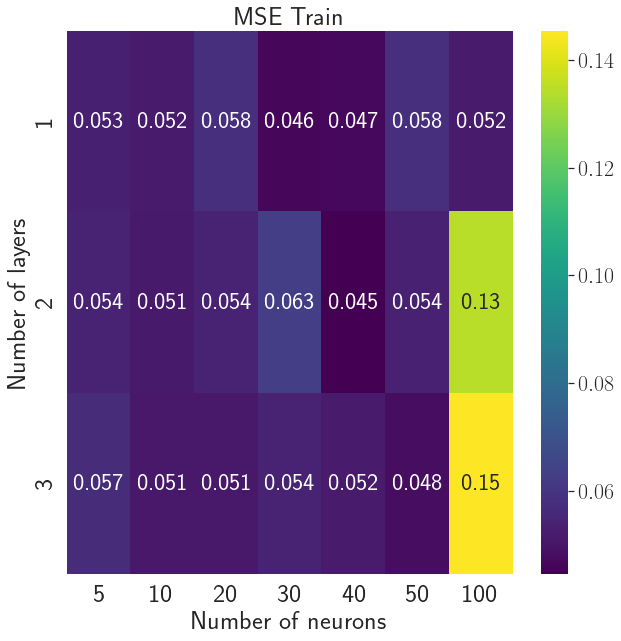

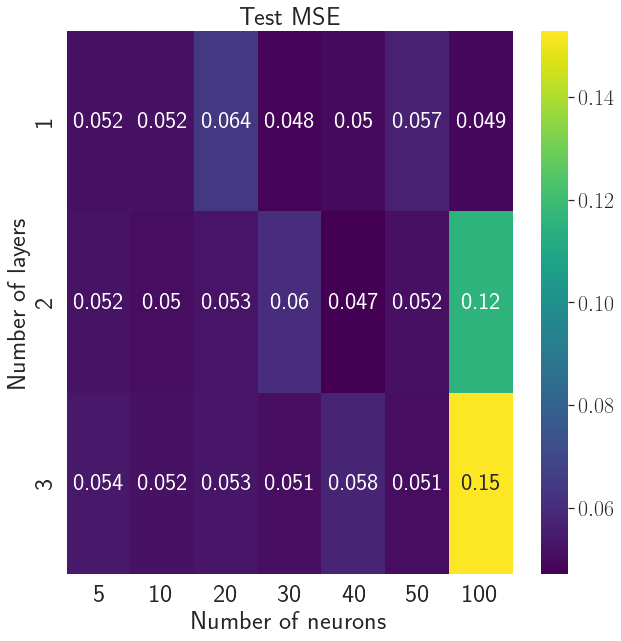

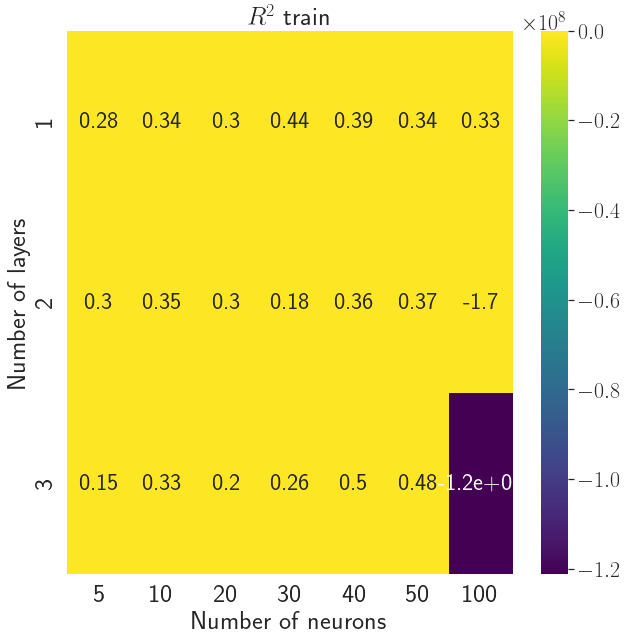

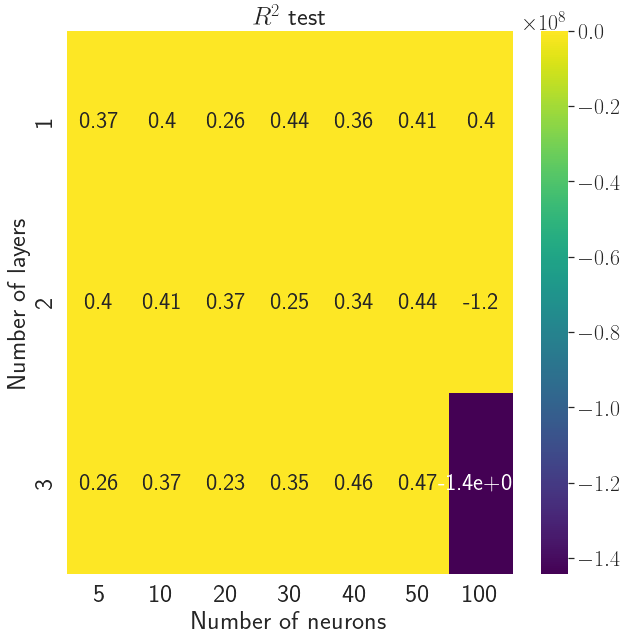

In [182]:
np.random.seed(113241)

layer_vals = [1, 2, 3]
neurons_vals = [5, 10, 20, 30, 40, 50, 100]
# store the models for later use
        
DNN_numpy = np.zeros((len(layer_vals), len(neurons_vals)), dtype=object)

# grid search
for i, layer in enumerate(layer_vals):
    for j, neurons in enumerate(neurons_vals):
        lneurons = [neurons for k in range(layer)]
        dNN = NN(X_train,
                 z_train,
                 n_neurons=lneurons,
                 epochs=100,
                 batch_size=10,
                 eta=0.01, 
                 lmbd=1e-4,
                 n_categories = 1, 
                 hidden_act_function = "sigmoid",
                 gamma = 0.0, 
                 last_act_function = "return input",
                 model="Regressor")
        dNN.train()
        
        DNN_numpy[i][j] = dNN
        
        test_predict = dNN.predict(X_test)
        train_predict = dNN.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Number of layers  = ", layer)
        print("Number of neurons in layers = ", neurons)
        print("MSE score on test set: ", MSE(z_test, test_predict))
        print("MSE score on train set: ", MSE(z_train, train_predict))
        print()
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

MSEtrain = np.zeros((len(layer_vals), len(neurons_vals)))
MSEtest = np.zeros((len(layer_vals), len(neurons_vals)))
R2train = np.zeros((len(layer_vals), len(neurons_vals)))
R2test = np.zeros((len(layer_vals), len(neurons_vals)))

for i in range(len(layer_vals)):
    for j in range(len(neurons_vals)):
        dNN = DNN_numpy[i][j]
        
        train_pred = dNN.predict(X_train) 
        test_pred = dNN.predict(X_test)
        
        MSEtrain[i][j] = MSE(train_pred, z_train)
        MSEtest[i][j] = MSE(test_pred, z_test)
        R2train[i][j] = R2(train_pred, z_train)
        R2test[i][j] = R2(test_pred, z_test)
        

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtrain, annot=True, ax=ax, cmap="viridis", yticklabels=layer_vals, xticklabels=neurons_vals)
ax.set_title("MSE Train", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtest, annot=True, ax=ax, cmap="viridis", yticklabels=layer_vals, xticklabels=neurons_vals)
ax.set_title("Test MSE", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2train, annot=True, ax=ax, cmap="viridis", yticklabels=layer_vals, xticklabels=neurons_vals)
ax.set_title("$R^2$ train", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2test, annot=True, ax=ax, cmap="viridis", yticklabels=layer_vals, xticklabels=neurons_vals)
ax.set_title("$R^2$ test", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_layers_neurons.pdf", format="pdf")
plt.show()

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of epochs  =  10000
Mini-batch size =  11
MSE score on test set:  0.07529272877151545
MSE score on train set:  0.03137187278249876

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of epochs  =  10000
Mini-batch size =  12
MSE score on test set:  0.054745452290265575
MSE score on train set:  0.03529213721389081

MODEL: Regressor
Hidden layer activation function: sigmoid
Output layer activation function: return input
Shape of test_predict:  (320, 1)
Shape of train_predict:  (1280, 1)
Number of epochs  =  10000
Mini-batch size =  13
MSE score on test set:  0.06999339911912596
MSE score on train set:  0.038651735025468814



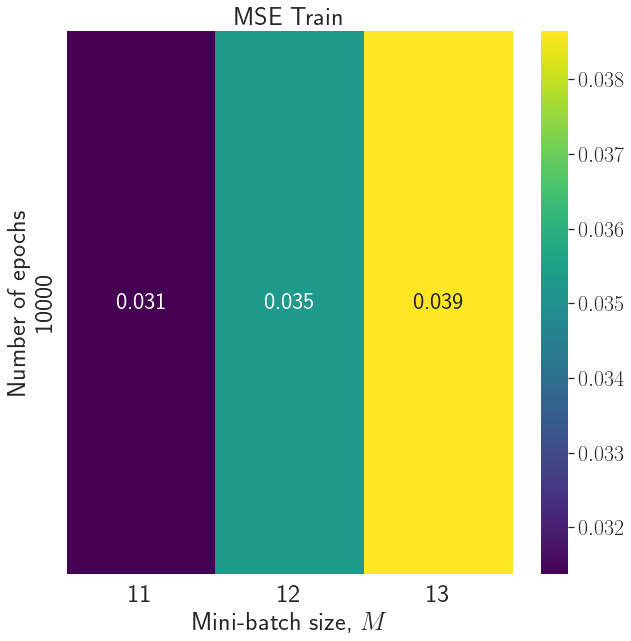

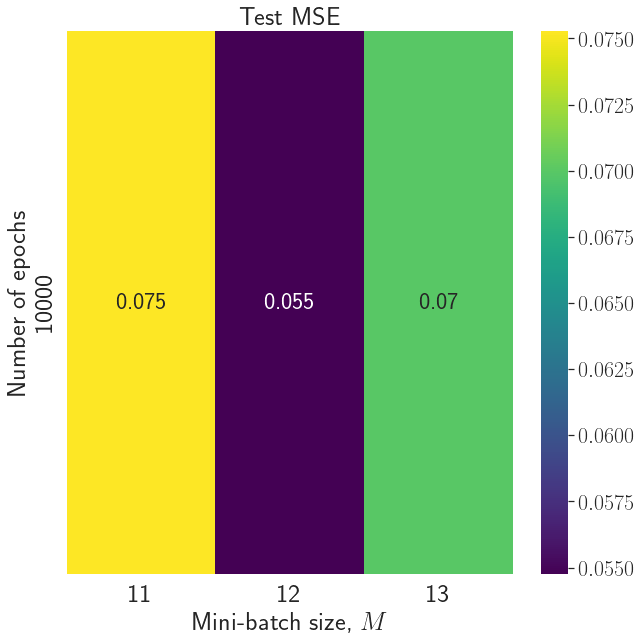

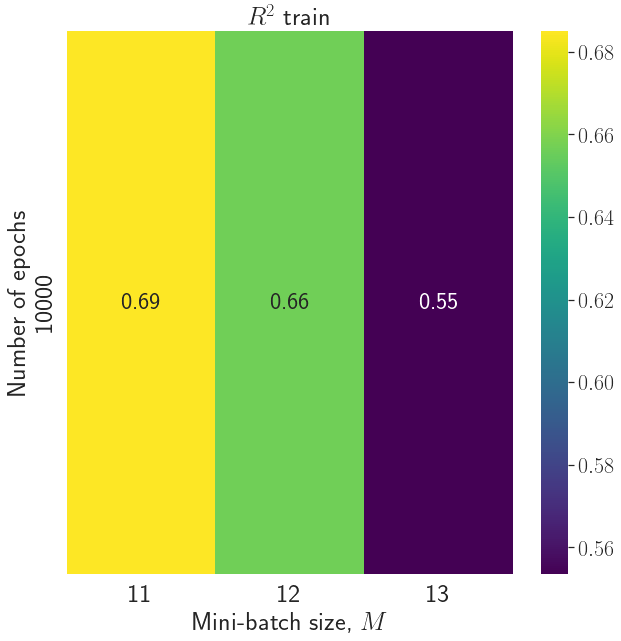

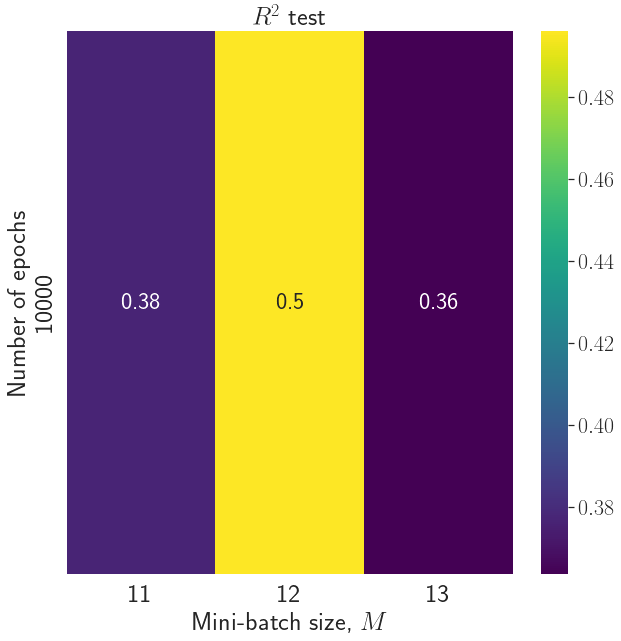

In [184]:
np.random.seed(113241)

epoch_vals = [10000]
b_s_vals = [11, 12, 13]
# store the models for later use
        
DNN_numpy = np.zeros((len(epoch_vals), len(b_s_vals)), dtype=object)

# grid search
for i, epoch in enumerate(epoch_vals):
    for j, b_s in enumerate(b_s_vals):
        dNN = NN(X_train,
                 z_train,
                 n_neurons=[40, 40, 40],
                 epochs=epoch,
                 batch_size=b_s,
                 eta=0.01, 
                 lmbd=1e-4, 
                 n_categories = 1, 
                 hidden_act_function = "sigmoid",
                 gamma = 0.0, 
                 last_act_function = "return input",
                 model="Regressor")
        dNN.train()
        
        DNN_numpy[i][j] = dNN
        
        test_predict = dNN.predict(X_test)
        train_predict = dNN.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Number of epochs  = ", epoch)
        print("Mini-batch size = ", b_s)
        print("MSE score on test set: ", MSE(z_test, test_predict))
        print("MSE score on train set: ", MSE(z_train, train_predict))
        print()
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

MSEtrain = np.zeros((len(epoch_vals), len(b_s_vals)))
MSEtest = np.zeros((len(epoch_vals), len(b_s_vals)))
R2train = np.zeros((len(epoch_vals), len(b_s_vals)))
R2test = np.zeros((len(epoch_vals), len(b_s_vals)))

for i in range(len(epoch_vals)):
    for j in range(len(b_s_vals)):
        dNN = DNN_numpy[i][j]
        
        train_pred = dNN.predict(X_train) 
        test_pred = dNN.predict(X_test)
        
        MSEtrain[i][j] = MSE(train_pred, z_train)
        MSEtest[i][j] = MSE(test_pred, z_test)
        R2train[i][j] = R2(train_pred, z_train)
        R2test[i][j] = R2(test_pred, z_test)
        

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtrain, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("MSE Train", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Mini-batch size, $M$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_MSE_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(MSEtest, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Test MSE", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Mini-batch size, $M$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_MSE_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2train, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("$R^2$ train", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Mini-batch size, $M$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_R2_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(R2test, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("$R^2$ test", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Mini-batch size, $M$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_R2_epoch_bs.pdf", format="pdf")
plt.show()

In [36]:
#Wisconsin Breast Cancer Data
np.random.seed(3155)

from sklearn.metrics import accuracy_score

from sklearn import datasets 
b = datasets.load_breast_cancer()

#print('feature names:'); print(b.feature_names); print()
#print('target names:'); print(b.target_names); print()
#print('target:'); print(b.target); print()
#print('data, X:'); print(b.data); print()

def to_categorical_numpy(integer_vector):
    n_inputs = len(integer_vector)
    n_categories = np.max(integer_vector) + 1
    onehot_vector = np.zeros((n_inputs, n_categories))
    onehot_vector[range(n_inputs), integer_vector] = 1
    
    return onehot_vector

X_train, X_test, y_train, y_test = train_test_split(b.data, b.target, test_size=0.2)
X_train_mean = np.mean(X_train, axis=0); # y_train_mean = np.mean(y_train, axis=0)
X_train -= X_train_mean; X_test -= X_train_mean;# y_train -= y_train_mean; y_test -= y_train_mean
y_train_onehot = to_categorical_numpy(y_train)
#print('y_train_onehot:'); print(y_train_onehot); print()
print(X_train.shape)
print(y_train.shape)

#testing with optimal lambda and eta
dNN = NN(X_train, 
         y_train_onehot, 
         n_neurons=[10], 
         batch_size=10, 
         epochs=1, 
         eta=1, 
         lmbd=0.1, 
         hidden_act_function='sigmoid', 
         last_act_function="softmax", 
         model='Classifier', 
         n_categories=2)
dNN.train()


probabilities = dNN.predict_probabilities(X_test)
#print('probabilities:'); print(probabilities)

#print(y_train_onehot)
train_pred = dNN.predict(X_train)
test_pred = dNN.predict(X_test)
#print('predicted classes:'); #print(test_pred)

print('accuracy score:'); print(accuracy_score(y_test, test_pred))
print("accuracy score train:"); print(accuracy_score(y_train, train_pred))

print()

print("MSE test: ", MSE(test_pred, y_test))

(455, 30)
(455,)
MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
accuracy score:
0.9473684210526315
accuracy score train:
0.9230769230769231

MSE test:  0.05263157894736842


<ipython-input-2-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-2-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1e-06
Lambda =  1e-06
Accuracy score on test set:  0.10526315789473684
Accuracy score on train set:  0.1076923076923077

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1e-06
Lambda =  1e-05
Accuracy score on test set:  0.6052631578947368
Accuracy score on train set:  0.6527472527472528

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1e-06
Lambda =  0.0001
Accuracy score on test set:  0.631578947368421
Accuracy score on train set:  0.6285714285714286

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation functi

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Accuracy score on test set:  0.05263157894736842
Accuracy score on train set:  0.06813186813186813

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1e-05
Lambda =  1.0
Accuracy score on test set:  0.2807017543859649
Accuracy score on train set:  0.24615384615384617

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.0001
Lambda =  1e-06
Accuracy score on test set:  0.32456140350877194
Accuracy score on train set:  0.3516483516483517

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.0001
Lambda =  1e-05
Accuracy score on test set:  0.42105263157894735
Accuracy score on train set:  0.421978

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.001
Lambda =  0.001
Accuracy score on test set:  0.9210526315789473
Accuracy score on train set:  0.9230769230769231

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.001
Lambda =  0.01
Accuracy score on test set:  0.631578947368421
Accuracy score on train set:  0.621978021978022

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.001
Lambda =  0.1
Accuracy score on test set:  0.9035087719298246
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.001
Lambda = 

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  0.1
Lambda =  1.0
Accuracy score on test set:  0.9649122807017544
Accuracy score on train set:  0.9274725274725275

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1.0
Lambda =  1e-06
Accuracy score on test set:  0.6491228070175439
Accuracy score on train set:  0.6703296703296703

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.9210526315789473
Accuracy score on train set:  0.9098901098901099

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Learning rate  =  1.0
Lambda =  0.00

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

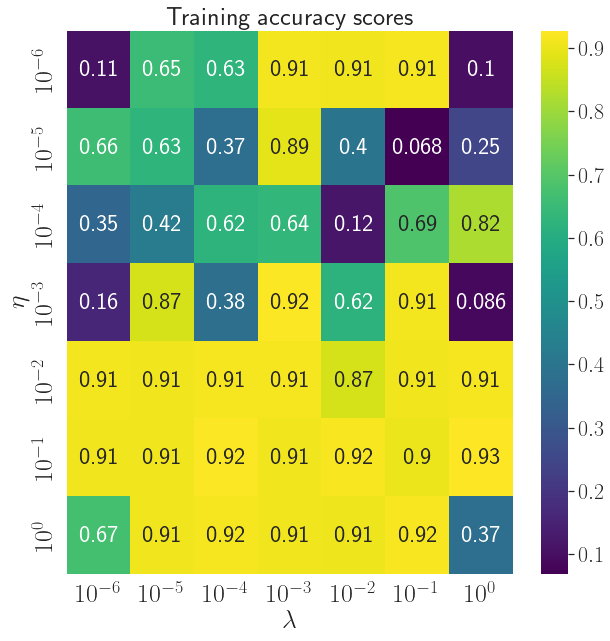

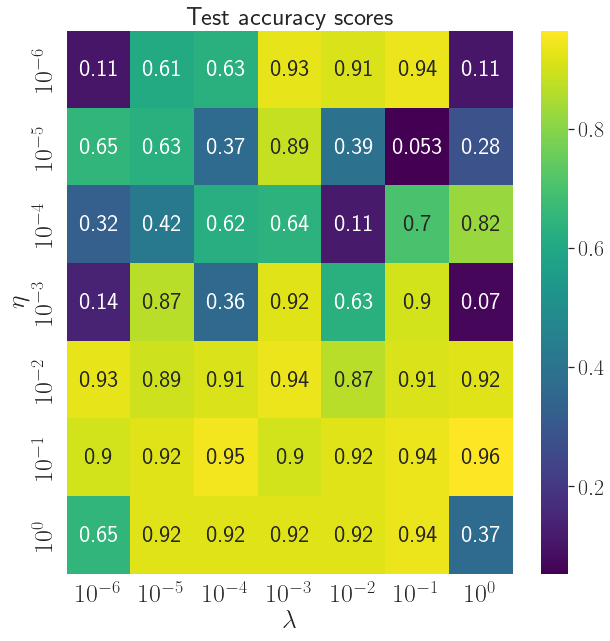

In [139]:
np.random.seed(113241)

eta_vals = np.logspace(-6, 0, 7)
lmbd_vals = np.logspace(-6, 0, 7)
# store the models for later use
tickseta_vals = []
tickslmbd_vals = []
for i in range(len(eta_vals)): 
    tickseta_vals.append(str(r'$10^{%.d}$'%(np.log10(eta_vals[i]))))
    tickslmbd_vals.append(str(r'$10^{%.d}$'%(np.log10(lmbd_vals[i]))))
        
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NN(X_train, y_train_onehot, eta=eta, lmbd=lmbd, epochs=1, batch_size=10,
                            n_neurons=[10], 
                            n_categories=2, hidden_act_function="sigmoid", 
                            last_act_function="softmax", model="Classifier")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()
        
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns
NORMAL = 26
sns.set(font_scale=2.0)

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("Training accuracy scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_acc_score_eta_lmb.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=tickseta_vals, xticklabels=tickslmbd_vals)
ax.set_title("Test accuracy scores", fontsize=NORMAL)
ax.set_ylabel("$\eta$", fontsize=NORMAL)
ax.set_xlabel("$\lambda$", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_acc_score_eta_lmb.pdf", format="pdf")
plt.show()

In [84]:

print([10 for i in range(10)])

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Layers:  1
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  1
Accuracy score on test set:  0.9385964912280702
Accuracy score on train set:  0.9164835164835164

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  1
Accuracy score on test set:  0.9210526315789473
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  2
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  2
Accuracy score on test set:  0.9298245614035088
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Layers:  2
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9076923076923077

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Layers:  2
Accuracy score on test set:  0.6842105263157895
Accur

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Layers:  2
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9142857142857143

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Layers:  3
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9208791208791208

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  3
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9032967032967033

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  3
Accuracy score on test set:  0.8947368421052632
Accur

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Layers:  3
Accuracy score on test set:  0.9298245614035088
Accuracy score on train set:  0.9142857142857143

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Layers:  4
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  4
Accuracy score on test set:  0.868421052631579
Accuracy score on train set:  0.8791208791208791

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  4
Accuracy score on test set:  0.9035087719298246
Accur

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Layers:  4
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Layers:  5
Accuracy score on test set:  0.631578947368421
Accuracy score on train set:  0.6263736263736264

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  5
Accuracy score on test set:  0.631578947368421
Accuracy score on train set:  0.6263736263736264

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  5
Accuracy score on test set:  0.9122807017543859
Accura

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Layers:  5
Accuracy score on test set:  0.8508771929824561
Accuracy score on train set:  0.8351648351648352

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Layers:  6
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Layers:  6
Accuracy score on test set:  0.631578947368421
Accuracy score on train set:  0.6263736263736264

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Layers:  6
Accuracy score on test set:  0.8947368421052632
Accur

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ip

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Layers:  6
Accuracy score on test set:  0.9298245614035088
Accuracy score on train set:  0.9164835164835164

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Layers:  6
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363



<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/

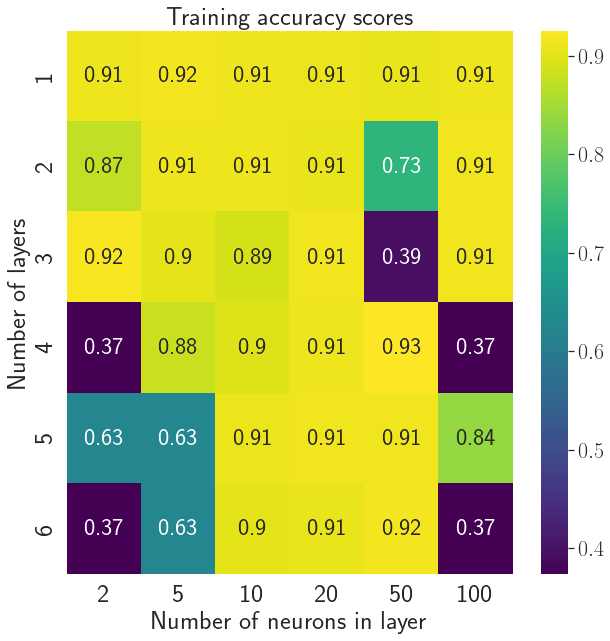

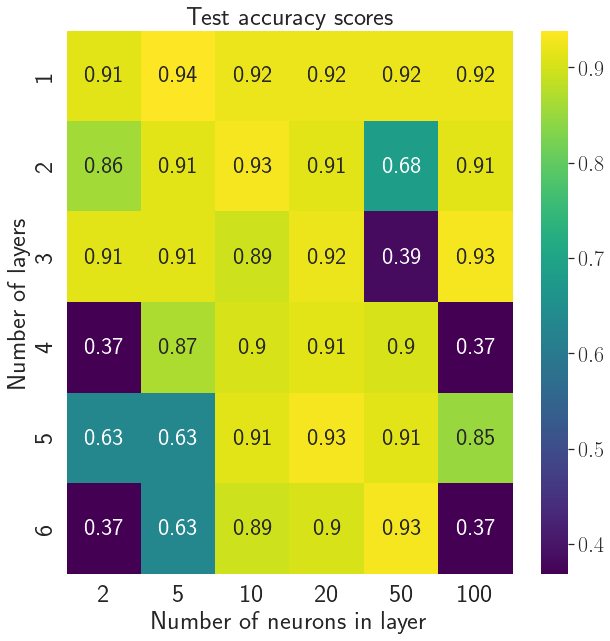

In [142]:
# visual representation of grid search
np.random.seed(113241)

n_layers = [1, 2, 3, 4, 5, 6]
n_neurons_vals = [2, 5, 10, 20, 50, 100]

# store the models for later use
DNN_numpy = np.zeros((len(n_neurons_vals), len(activation_functions)), dtype=object)

# grid search
for i, n_layer in enumerate(n_layers):
    for j, neurons in enumerate(n_neurons_vals): 
        lneurons = [neurons for j in range(n_layer)]
        dnn = NN(X_train, y_train_onehot, eta=0.1, lmbd=1e-4, epochs=1, batch_size=10,
                            n_neurons=lneurons, 
                            n_categories=2, hidden_act_function="sigmoid", 
                            last_act_function="softmax", model="Classifier")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Neurons: ", neurons)
        print("Layers: ", n_layer)
        print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
NORMAL = 26
sns.set(font_scale=2.0)

train_accuracy = np.zeros((len(n_neurons_vals), len(activation_functions)))
test_accuracy = np.zeros((len(n_neurons_vals), len(activation_functions)))

for i in range(len(n_neurons_vals)):
    for j in range(len(activation_functions)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Training accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons in layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_acc_score_layers_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=n_layers, xticklabels=n_neurons_vals)
ax.set_title("Test accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Number of layers", fontsize=NORMAL)
ax.set_xlabel("Number of neurons in layer", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_acc_score_layers_neurons.pdf", format="pdf")
plt.show()

In [103]:
print(train_accuracy[1][4])
print(test_accuracy[1][4])

0.9406593406593406
0.9385964912280702


MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1
Batch size =  10
Accuracy score on test set:  0.9035087719298246
Accuracy score on train set:  0.8923076923076924

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe0

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  5
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  5
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  5
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  5
Batch size =  20
Accuracy score on test set:  0.3684

<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe0

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  20
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517c

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  30
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  50
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  20
Batch size =  100
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: R

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  20
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  30
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  50
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  50
Batch size =  100
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  20
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  30
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  50
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  100
Batch size =  100
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  20
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  30
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  50
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  500
Batch size =  100
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  1
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  5
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  10
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  20
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  30
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  50
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax


<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-113-ab15517cbe00>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Epochs:  1000
Batch size =  100
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363



<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-113-ab15517cbe00>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))


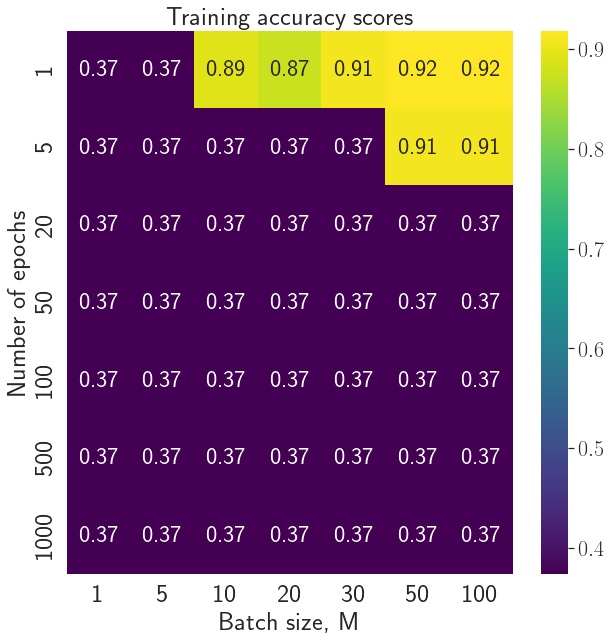

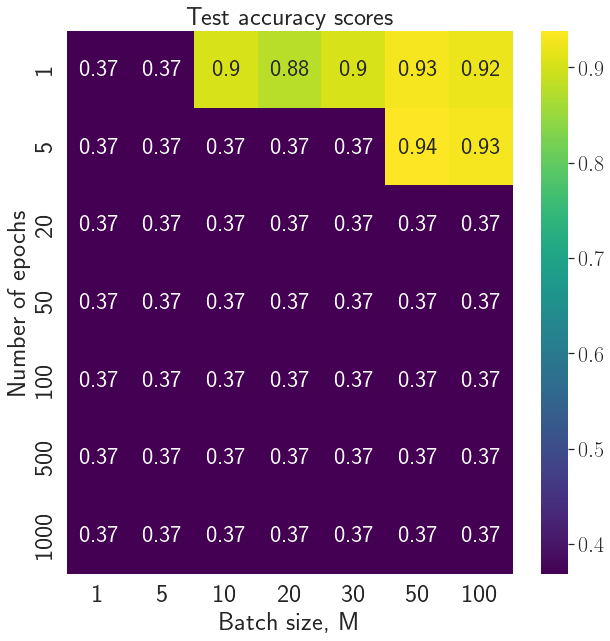

In [143]:
np.random.seed(113241)

epoch_vals = [1, 5, 20, 50, 100, 500, 1000]
b_s_vals = [1, 5, 10, 20, 30, 50, 100]

# store the models for later use
DNN_numpy = np.zeros((len(epoch_vals), len(b_s_vals)), dtype=object)

# grid search
for i, epoch in enumerate(epoch_vals):
    for j, b_s in enumerate(b_s_vals):
        dnn = NN(X_train, y_train_onehot, eta=0.1, lmbd=1, epochs=epoch, batch_size=b_s,
                            n_neurons=[5], 
                            n_categories=2, hidden_act_function="sigmoid", 
                            last_act_function="softmax", model="Classifier")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Epochs: ", epoch)
        print("Batch size = ", b_s)
        print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
NORMAL = 26
sns.set(font_scale=2.0)

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(epoch_vals)):
    for j in range(len(b_s_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Training accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Batch size, M", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_acc_score_epoch_bs.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=epoch_vals, xticklabels=b_s_vals)
ax.set_title("Test accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Number of epochs", fontsize=NORMAL)
ax.set_xlabel("Batch size, M", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_acc_score_epoch_bs.pdf", format="pdf")
plt.show()

In [63]:
best_epoch = 100
best_b_s = 10

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.9035087719298246
Accuracy score on train set:  0.9032967032967033

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.9210526315789473
Accuracy score on train set:  0.9076923076923077

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: invalid value encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: invalid value encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:92: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x>0)*x)
<ipython-input-70-2b586e3e8959>:93: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x<=0)*x*0.01)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  2
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9120879120879121

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.9473684210526315
Accuracy score on train set:  0.9252747252747253

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: invalid value encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:92: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x>0)*x)
<ipython-input-70-2b586e3e8959>:93: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x<=0)*x*0.01)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  5
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.8947368421052632
Accuracy score on train set:  0.9098901098901099

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9076923076923077

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: invalid value encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:248: RuntimeWarning: overflow encountered in multiply
  self.hidden_bias[layer] -= self.eta*self.hidden_bias_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  10
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.8859649122807017
Accuracy score on train set:  0.9274725274725275

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
/home/jeb/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:247

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:92: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x>0)*x)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  20
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.9122807017543859
Accuracy score on train set:  0.9230769230769231

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: invalid value encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:206: RuntimeWarning: invalid value encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: invalid value encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:92: RuntimeWarning: invalid value encountered in multiply
  y1 = ((x>0)*x)
<ipython-input-70-2b586e3e8959>:93: RuntimeWarning: invalid va

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  50
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: sigmoid
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:78: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: sigmoid
Output act func: binary classifier
Accuracy score on test set:  0.8859649122807017
Accuracy score on train set:  0.9296703296703297

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: reLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: reLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:206: RuntimeWarning: invalid value encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:244: RuntimeWarning: overflow encountered in multiply
  self.output_weights -= self.eta*self.output_weights_gradient
<ipython-input-70-2b586e3e8959>:247: RuntimeWarning: overflow encountered in multiply
  self.hidden_weights[layer] -= self.eta * self.hidden_weights_gradients[self.n_layers-1-layer]
<ipython-input-70-2b586e3e895

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: reLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: softmax
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:103: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-70-2b586e3e8959>:104: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: leakyReLU
Output act func: softmax
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363

MODEL: Classifier
Hidden layer activation function: leakyReLU
Output layer activation function: binary classifier
X_data shape:  (455, 30)


<ipython-input-70-2b586e3e8959>:182: RuntimeWarning: overflow encountered in matmul
  self.z_o = np.matmul(self.a_h[-1], self.output_weights) + self.output_bias
<ipython-input-70-2b586e3e8959>:165: RuntimeWarning: overflow encountered in matmul
  z_h_temp = np.matmul(self.X_data, self.hidden_weights[0]) + self.hidden_bias[0]
<ipython-input-70-2b586e3e8959>:93: RuntimeWarning: invalid value encountered in multiply
  y2 = ((x<=0)*x*0.01)
<ipython-input-70-2b586e3e8959>:200: RuntimeWarning: overflow encountered in matmul
  error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h_der[-1]
<ipython-input-70-2b586e3e8959>:206: RuntimeWarning: overflow encountered in matmul
  self.output_weights_gradient = np.matmul(self.a_h[-1].T, error_output)
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: overflow encountered in matmul
  hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
<ipython-input-70-2b586e3e8959>:216: RuntimeWarning: invalid value encountered in mat

Shape of test_predict:  (114,)
Shape of train_predict:  (455,)
Neurons:  100
Activation functions: leakyReLU
Output act func: binary classifier
Accuracy score on test set:  0.3684210526315789
Accuracy score on train set:  0.37362637362637363



<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-70-2b586e3e8959>:74: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.e

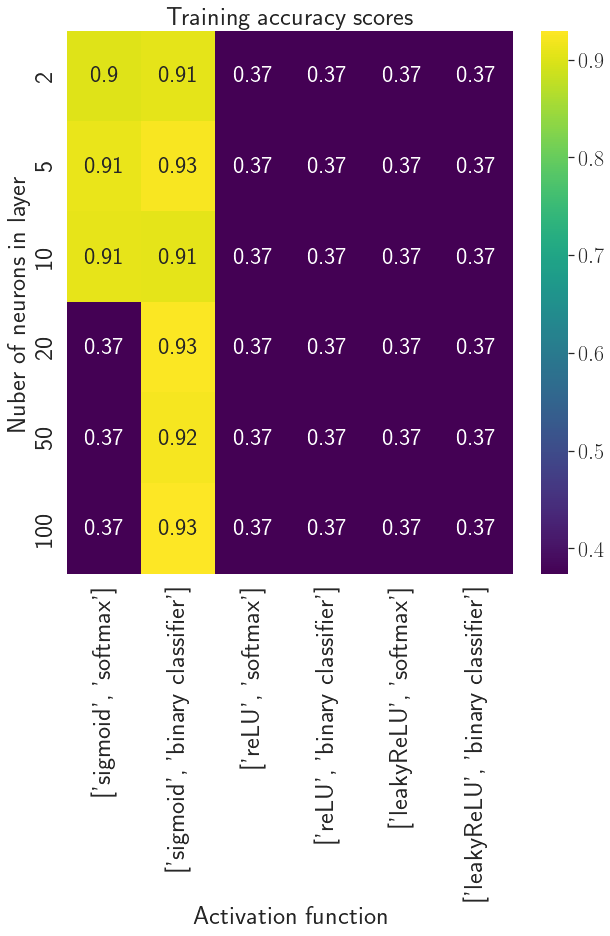

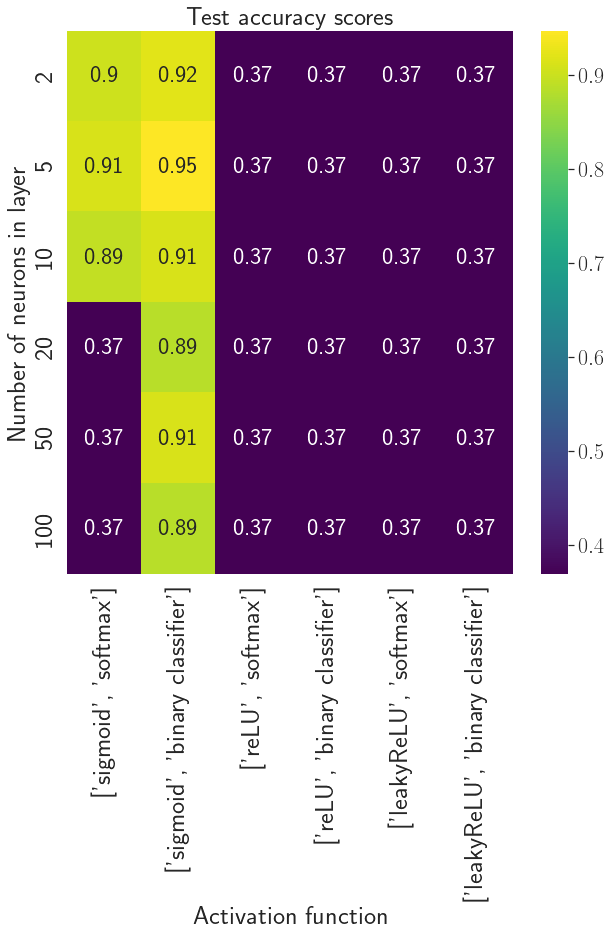

In [76]:
np.random.seed(0)

activation_functions = [["sigmoid", "softmax"], ["sigmoid", "binary classifier"], ["reLU", "softmax"], ["reLU", "binary classifier"], ["leakyReLU", "softmax"], ["leakyReLU", "binary classifier"]]
n_neurons_vals = [2, 5, 10, 20, 50, 100]

# store the models for later use
DNN_numpy = np.zeros((len(n_neurons_vals), len(activation_functions)), dtype=object)

# grid search
for i, neurons in enumerate(n_neurons_vals):
    for j, activation_function in enumerate(activation_functions): 
        dnn = NN(X_train, y_train_onehot, eta=best_eta, lmbd=best_lmbd, epochs=best_epoch, batch_size=best_b_s,
                            n_neurons=[neurons], 
                            n_categories=2, hidden_act_function=activation_function[0], 
                            last_act_function=activation_function[1], model="Classifier")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Neurons: ", neurons)
        print("Activation functions: " + activation_function[0])
        print("Output act func: " + activation_function[1])
        print("Accuracy score on test set: ", accuracy_score(y_test, test_predict))
        print("Accuracy score on train set: ", accuracy_score(y_train, train_predict))
        print()
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
NORMAL = 26
sns.set(font_scale=2.0)

train_accuracy = np.zeros((len(n_neurons_vals), len(activation_functions)))
test_accuracy = np.zeros((len(n_neurons_vals), len(activation_functions)))

for i in range(len(n_neurons_vals)):
    for j in range(len(activation_functions)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=n_neurons_vals, xticklabels=activation_functions)
ax.set_title("Training accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Nuber of neurons in layer", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("train_acc_score_activation_neurons.pdf", format="pdf")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis", yticklabels=n_neurons_vals, xticklabels=activation_functions)
ax.set_title("Test accuracy scores", fontsize=NORMAL)
ax.set_ylabel("Number of neurons in layer", fontsize=NORMAL)
ax.set_xlabel("Activation function", fontsize=NORMAL)
ax.tick_params(labelsize=NORMAL)
plt.savefig("test_acc_score_activation_neurons.pdf", format="pdf")
plt.show()

In [264]:
from sklearn import datasets

# download MNIST dataset
digits = datasets.load_digits()

# define inputs and labels
inputs = digits.images
labels = digits.target

n_inputs = len(inputs)
inputs = inputs.reshape(n_inputs, -1)

train_size = 0.8
test_size = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,
                                                    test_size=test_size)

n_hidden_neurons = 50
n_categories = 10

Y_train_onehot, Y_test_onehot = to_categorical_numpy(Y_train), to_categorical_numpy(Y_test)

dnn = NN(X_train,Y_train_onehot,n_neurons=[100], epochs=100,batch_size=10,eta=0.01, lmbd=0.01, n_categories = 10, 
         hidden_act_function = "sigmoid",last_act_function = "softmax",model="Classifier")
dnn.train()
print(X_test.shape)
pred = dnn.predict(X_test)
print(pred.shape)
print(Y_test_onehot.shape)

print(accuracy_score(pred, Y_test))

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
(360, 64)
(360,)
(360, 10)
0.975


In [276]:
np.random.seed(0)

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
# store the models for later use
DNN_numpy = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)

# grid search
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = NN(X_train, Y_train_onehot, eta=eta, lmbd=lmbd, epochs=100, batch_size=10,
                            n_neurons=[10], 
                            n_categories=10, hidden_act_function="sigmoid", 
                            last_act_function="softmax", model="Classifier")
        dnn.train()
        
        DNN_numpy[i][j] = dnn
        
        test_predict = dnn.predict(X_test)
        train_predict = dnn.predict(X_train)
        
        print("Shape of test_predict: ", (test_predict.shape))
        print("Shape of train_predict: ", (train_predict.shape))
        
        print("Learning rate  = ", eta)
        print("Lambda = ", lmbd)
        print("Accuracy score on test set: ", accuracy_score(Y_test, test_predict))
        print("Accuracy score on train set: ", accuracy_score(Y_train, train_predict))
        print()

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1e-05
Lambda =  1e-05
Accuracy score on test set:  0.175
Accuracy score on train set:  0.14265831593597772

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1e-05
Lambda =  0.0001
Accuracy score on test set:  0.08333333333333333
Accuracy score on train set:  0.09324982602644398

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1e-05
Lambda =  0.001
Accuracy score on test set:  0.1638888888888889
Accuracy score on train set:  0.1725

Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.01
Lambda =  0.01
Accuracy score on test set:  0.9111111111111111
Accuracy score on train set:  0.954070981210856

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.01
Lambda =  0.1
Accuracy score on test set:  0.9444444444444444
Accuracy score on train set:  0.9568545581071677

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.01
Lambda =  1.0
Accuracy score on test set:  0.7527777777777778
Accuracy score on train set:  0.8009742519137091

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape

<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.1
Lambda =  1e-05
Accuracy score on test set:  0.5722222222222222
Accuracy score on train set:  0.6416144745998609

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.1
Lambda =  0.0001
Accuracy score on test set:  0.6583333333333333
Accuracy score on train set:  0.6764091858037579

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.1
Lambda =  0.001
Accuracy score on test set:  0.5805555555555556
Accuracy score on train set:  0.6249130132219902

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.1
Lambda =  0.01
Accuracy score on test set:  0.3861111111111111
Accuracy score on train set:  0.3444676409185804

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)
Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  0.1
Lambda =  0.1
Accuracy score on test set:  0.10277777777777777
Accuracy score on train set:  0.10020876826722339

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data sha

<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  1e-05
Accuracy score on test set:  0.10555555555555556
Accuracy score on train set:  0.09812108559498957

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  0.0001
Accuracy score on test set:  0.06666666666666667
Accuracy score on train set:  0.10925539318023661

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  0.001
Accuracy score on test set:  0.10277777777777777
Accuracy score on train set:  0.10020876826722339

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  0.01
Accuracy score on test set:  0.09166666666666666
Accuracy score on train set:  0.10020876826722339

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  0.1
Accuracy score on test set:  0.06666666666666667
Accuracy score on train set:  0.10925539318023661

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  1.0
Accuracy score on test set:  0.07777777777777778
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:101: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-262-de7d97aaa3aa>:102: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  1.0
Lambda =  10.0
Accuracy score on test set:  0.08888888888888889
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:101: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-262-de7d97aaa3aa>:102: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  1e-05
Accuracy score on test set:  0.08888888888888889
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  0.0001
Accuracy score on test set:  0.07777777777777778
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  0.001
Accuracy score on test set:  0.08888888888888889
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  0.01
Accuracy score on test set:  0.1361111111111111
Accuracy score on train set:  0.09116214335421016

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  0.1
Accuracy score on test set:  0.06666666666666667
Accuracy score on train set:  0.10925539318023661

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:101: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-262-de7d97aaa3aa>:102: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  1.0
Accuracy score on test set:  0.08888888888888889
Accuracy score on train set:  0.10160055671537926

MODEL: Classifier
Hidden layer activation function: sigmoid
Output layer activation function: softmax
X_data shape:  (1437, 64)


<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:76: RuntimeWarning: overflow encountered in exp
  a = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:101: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp(x)
<ipython-input-262-de7d97aaa3aa>:102: RuntimeWarning: invalid value encountered in true_divide
  output = exp_term/np.sum(exp_term, axis=1, keepdims=True)


Classifier
Shape of test_predict:  (360,)
Shape of train_predict:  (1437,)
Learning rate  =  10.0
Lambda =  10.0
Accuracy score on test set:  0.08888888888888889
Accuracy score on train set:  0.10160055671537926



<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))
<ipython-input-262-de7d97aaa3aa>:72: RuntimeWarning: overflow encountered in exp
  output = 1.0/(1.0+np.exp(-x))


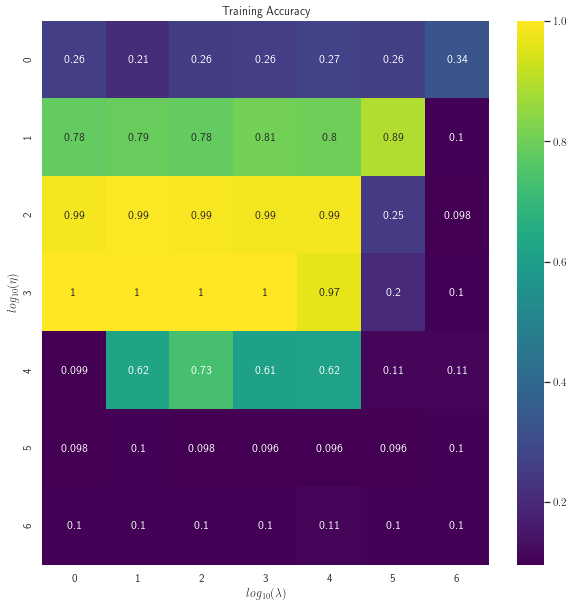

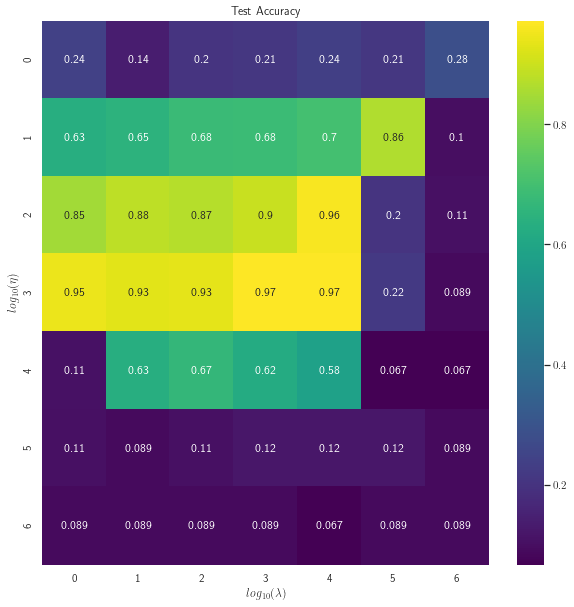

In [275]:
# visual representation of grid search
# uses seaborn heatmap, you can also do this with matplotlib imshow
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        dnn = DNN_numpy[i][j]
        
        train_pred = dnn.predict(X_train) 
        test_pred = dnn.predict(X_test)

        train_accuracy[i][j] = accuracy_score(Y_train, train_pred)
        test_accuracy[i][j] = accuracy_score(Y_test, test_pred)

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$log_{10}(\eta)$")
ax.set_xlabel("$log_{10}(\lambda)$")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$log_{10}(\eta)$")
ax.set_xlabel("$log_{10}(\lambda)$")
#ax.set_yticks([-5, -4, -3, -2, -1, 0, 1])
#ax.set_xticks([-5, -4, -3, -2, -1, 0, 1])
plt.show()

In [ ]:
for i in range(len(eta_vals)): 
    tickseta_vals.append(str('{:.2e}'.format(eta_vals[i])))
    tickslmbd_vals.append(str('{:.2e}'.format(lmbd_vals[i])))